# Environment Setting

* In Colab, by default, Tensorflow's version is r1.13. If we would like to use Tensorflow 2.0, a manual installation via pip command is required.

* Moreover, some ultilities are also imported, like numpy, pandas(csv file operations), and seaborn(visualization).

NOTE: If we don't need to utilize GPU, we could directly run command: *"!pip install tensorflow=2.0.0-alpha0"*. Otherwise, the GPU version should be installed.

In [1]:
# core libraries
import tensorflow as tf
import tensorflow.keras as tk

# utilities
import numpy as np
import scipy.stats
import sklearn
import sklearn.manifold
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import colors
from matplotlib.patches import Rectangle

import seaborn as sns
import pandas as pd
import os, datetime, copy

from math import ceil, floor
from itertools import islice

import pickle
import urllib.request

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Different Embedding Methods: MDS, t-SNE etc.

MDS for Input RDMs of all MLPs and CNNs, as well as their confusion matrices

In [0]:
# Dataframe, which contains all necessary infos about our trained models
# 1) index
# 2) "Unnamed: 0": model number
# 3) "acc": accuracy of this trained model
# 4) "loc": file name for model's final checkpoint
# 5) "model_type": 0-MLP, 1-CNN
# 6) "index": the same with "Unnamed: 0", viz., model number
acc_df = pd.read_csv('gdrive/My Drive/NI Project - RSA/euclidean_fashionmnist2_400_df.csv')
conv_index = acc_df['model_type']==1
mlp_index = acc_df['model_type']==0

# Model RDMs based on Euclidean distance of all models
all_models = pd.read_csv('gdrive/My Drive/NI Project - RSA/euclidean_fashionmnist2_400.csv').to_numpy()
# Remove the first column(model index)
all_models = all_models[:,1:]
# Euclidean model RDM for all CNNs
rdm_convnet = all_models[:,conv_index][conv_index,:]
# Euclidean model RDM for all MLPs
rdm_mlp = all_models[:,mlp_index][mlp_index,:] 

In [0]:
# All MLPs' accuracies 
with open ('gdrive/My Drive/NI Project - RSA/acc_mlp_fashionmnist_rsa_final_2.pkl', 'rb') as fp:
  acc_list_mlp = pickle.load(fp)

# All CNNs' accuracies
with open ('gdrive/My Drive/NI Project - RSA/acc_conv_fashionmnist_rsa_final.pkl', 'rb') as fp:
  acc_list_convnet = pickle.load(fp)

# Construct a dataframe for all MLPs
# 1) index
# 2) "acc": model's accuracy
# 3) "loc": file name of model's final checkpoint 
# 4) "model_type": 0-MLP
acc_df_mlp = pd.DataFrame(acc_list_mlp, columns = ['acc', 'loc'])
acc_df_mlp['model_type'] = np.zeros(len(acc_df_mlp))

# Construct a dataframe for all CNNs
# 1) index
# 2) "acc": model's accuracy
# 3) "loc": file name of model's final checkpoint 
# 4) "model_type": 1-CNN
acc_df_convnet = pd.DataFrame(acc_list_convnet, columns = ['acc', 'loc'])
acc_df_convnet['model_type'] = np.ones(len(acc_df_convnet))


# Concatenate the above two dataframe into one to describe all models
acc_df = pd.concat([acc_df_mlp,acc_df_convnet], axis=0, ignore_index = True)
acc_df['index'] = acc_df.index
# Sorting the new dataframe by accuracy
acc_df = acc_df.sort_values(by = 'acc', ascending = True)
acc_fashion = acc_df['acc']

# Sorting CNNs' and MLPs' dataframes separately by their accuracy
acc_convnet = acc_df_convnet.sort_values(by = 'acc', ascending = True)
acc_convnet = acc_convnet['acc']

acc_mlp = acc_df_mlp.sort_values(by = 'acc', ascending = True)
acc_mlp = acc_mlp['acc']

# According to the precomputed Euclidean model RDMs, that describes the dissimilarity between models,
# calculate embedding 2D-coordinates(controlled by "n_components") using multi-dimensional scaling(MDS) embedding method.
# Each coordinate represents a model, either MLP or CNN.
embedding = sklearn.manifold.MDS(n_components=2, metric = True, dissimilarity='precomputed')
embed_model = embedding.fit_transform(all_models)

# Select all models that have over 70% accuracy
over_70 = np.where(acc_fashion<0.7)[0][-1]+1
# Re-calculate coordinates for models with over 70% accuracy(high-performing models)
embed_good_model = embedding.fit_transform(all_models[over_70:,over_70:])

# Calculate embedding coordinates respectively for only MLPs and only CNNs
cnn_models = embedding.fit_transform(rdm_convnet)
mlp_models = embedding.fit_transform(rdm_mlp)

In [12]:
# Confusion matrices for all models
with open ('gdrive/My Drive/NI Project - RSA/confusion_dict_fashionmnist_final2.pkl', 'rb') as fp:
  confusion_dic = pickle.load(fp)

# 1) Flatten 2D-confusion matrix to 1D-array
for i in range(len(confusion_dic)):
  confusion_dic[i] = confusion_dic[i].flatten()
# 2) Construct 2D-array for all confusion matrices  
confusion_dic_array = np.array(list(confusion_dic.values()))
print(confusion_dic_array.shape)

# Apply MDS method to all confusion matrices, and obtain 2D-coordinates for all models
embedding = sklearn.manifold.MDS(n_components=2, metric = True)
embed_confusion = embedding.fit_transform(confusion_dic_array)

(653, 100)


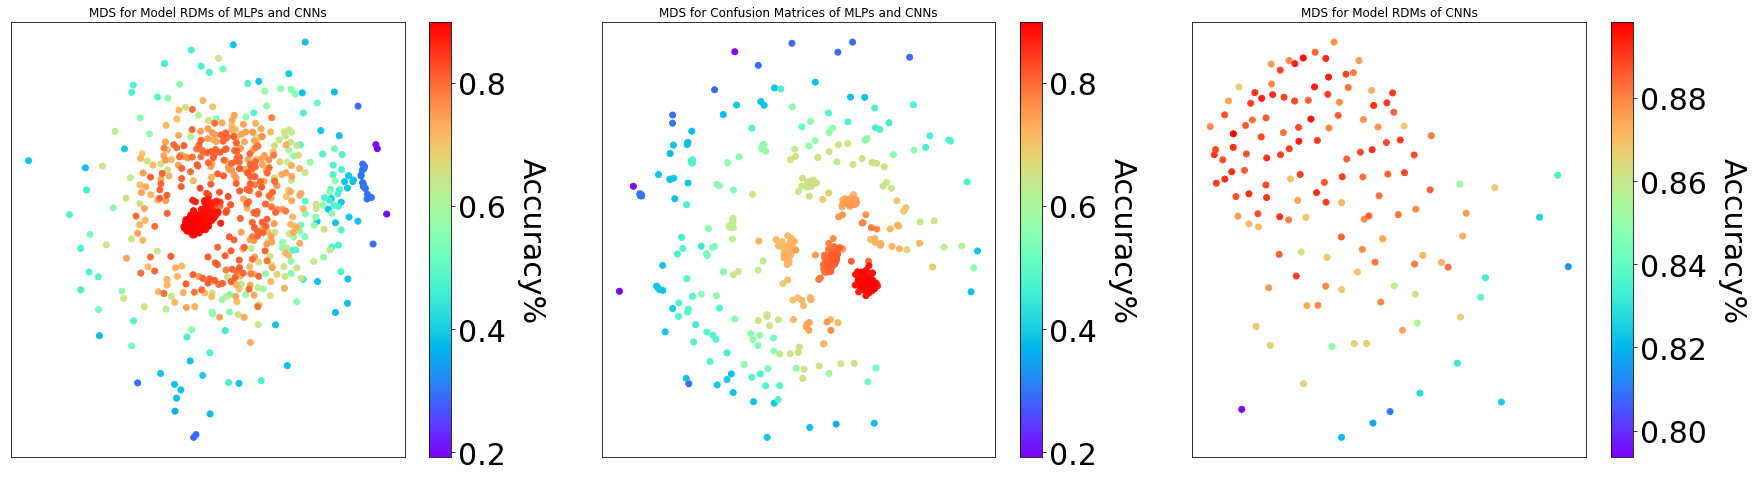

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(30, 8))
for i, ax in enumerate(axes.flat):
  if i == 0:
    # Plot embedding points based on Euclidean model RDMs 
    # Color points referring to their accuracies: red-high accuracy, blue-low accuracy
    points = ax.scatter(embed_model[:, 0], embed_model[:, 1], c=acc_fashion, cmap='rainbow')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('MDS for Model RDMs of MLPs and CNNs')
    cbar = fig.colorbar(points, ax=ax)
    cbar.ax.tick_params(labelsize=30)
    cbar.set_label('Accuracy%', labelpad=40, rotation=-90, size=30)
  elif i == 1:
    # Plot embedding points based on confusion matrices of all models
    points = ax.scatter(embed_confusion[:, 0], embed_confusion[:, 1], c=acc_fashion, cmap='rainbow')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('white')
    ax.set_title('MDS for Confusion Matrices of MLPs and CNNs')
    cbar = fig.colorbar(points, ax=ax)
    cbar.ax.tick_params(labelsize=30)
    cbar.set_label('Accuracy%', labelpad=40, rotation=-90, size=30)
  elif i == 2:
    # Plot embedding results based on all CNN models
    points = ax.scatter(cnn_models[:, 0], cnn_models[:, 1], c=acc_convnet, cmap='rainbow')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('MDS for Model RDMs of CNNs')
    cbar = fig.colorbar(points, ax=ax)
    cbar.ax.tick_params(labelsize=30)
    cbar.set_label('Accuracy%', labelpad=40, rotation=-90, size=30)

MDS for Input RDMs of all and over 70% Accuracy MLP Models, based on Euclidean distance

In [0]:
# Calculate embedding coordinates only for MLPs and high-performing MLPs(accuracy over 70%)
embedding = sklearn.manifold.MDS(n_components=2, metric = True, dissimilarity='precomputed')
mlp_model = embedding.fit_transform(rdm_mlp)
mlp_good_model = embedding.fit_transform(rdm_mlp[over_70:,over_70:])

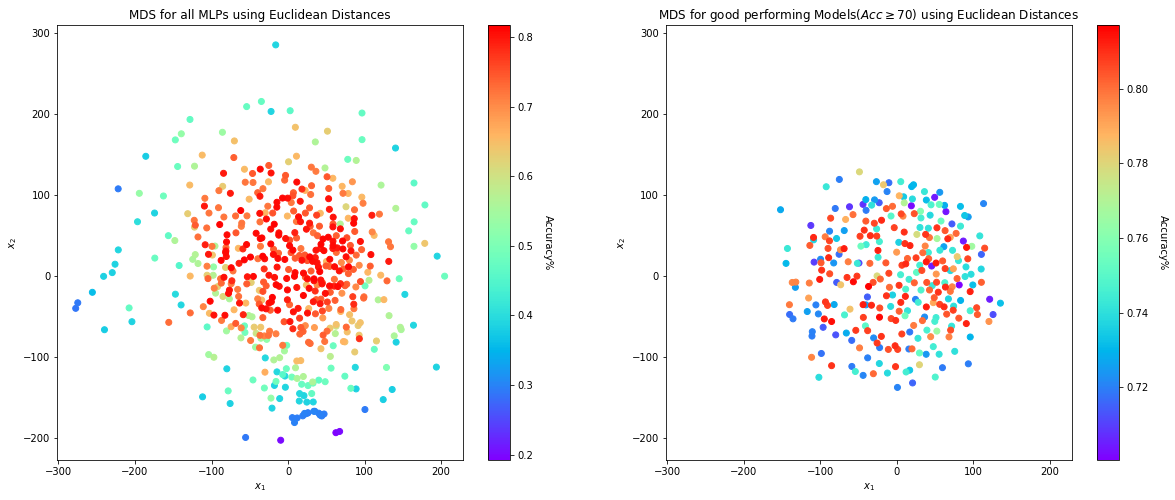

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
x_lim = y_lim = None
for i, ax in enumerate(axes.flat):
  if i == 0:
    # Plot embedding results for all MLPs
    points = ax.scatter(mlp_model[:, 0], mlp_model[:, 1], c=acc_mlp, cmap='rainbow')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_title('MDS for all MLPs using Euclidean Distances')
    # Make these two plots same scales in both dimensionalities.
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    
    cbar = fig.colorbar(points, ax=ax)
    cbar.set_label('Accuracy%', labelpad=20, rotation=-90)
  else:
    # Plot embedding results for high-performing MPL models.
    points = ax.scatter(mlp_good_model[:, 0], mlp_good_model[:, 1], c=acc_mlp[over_70:], cmap='rainbow')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_title(r'MDS for good performing Models($Acc \geq 70%$) using Euclidean Distances')
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    cbar = fig.colorbar(points, ax=ax)
    cbar.set_label('Accuracy%', labelpad=20, rotation=-90)

Apply the above procedure for the MNIST dataset

In [0]:
# Load Euclidean model RDM based on MNIST dataset
mnist_rdm = pd.read_csv('gdrive/My Drive/NI Project - RSA/mnist_rdm.csv').to_numpy()
mnist_rdm = mnist_rdm[:,1:]

# All MLP models' accuracies
with open ('gdrive/My Drive/NI Project - RSA/acc_mlp_mnist_rsa_final.pkl', 'rb') as fp:
  acc_list_mlp = pickle.load(fp)
# All CNN models' accuracies
with open ('gdrive/My Drive/NI Project - RSA/acc_conv_mnist_rsa_final.pkl', 'rb') as fp:
  acc_list_convnet = pickle.load(fp)

# Construct a dataframe for all models(both CNNs and MLPs)
# 1) index
# 2) "acc": model's accuracy
# 3) "loc": file name of model's final checkpoint 
# 4) "model_type": 0-MLP, 1-CNN
# Sorting dataframe ascending by model's accuracy
acc_df_mlp = pd.DataFrame(acc_list_mlp, columns = ['acc', 'loc'])
acc_df_mlp['model_type'] = np.zeros(len(acc_df_mlp))

acc_df_convnet = pd.DataFrame(acc_list_convnet, columns = ['acc', 'loc'])
acc_df_convnet['model_type'] = np.ones(len(acc_df_convnet))

acc_df = pd.concat([acc_df_mlp,acc_df_convnet], axis=0, ignore_index = True)
acc_df['index'] = acc_df.index
acc_df = acc_df.sort_values(by = 'acc', ascending = True)
acc_mnist = acc_df['acc']

# Perform MDS on the precomputed model RDM to obtain embedding results
embedding = sklearn.manifold.MDS(n_components=2, metric = True, dissimilarity='precomputed')
mnist_model = embedding.fit_transform(mnist_rdm)
# Filter out high-performing MPL models, that have a over 70% accuracy
over_70 = np.where(acc_mnist<0.7)[0][-1]+1
mnist_good_model = embedding.fit_transform(mnist_rdm[over_70:,over_70:])

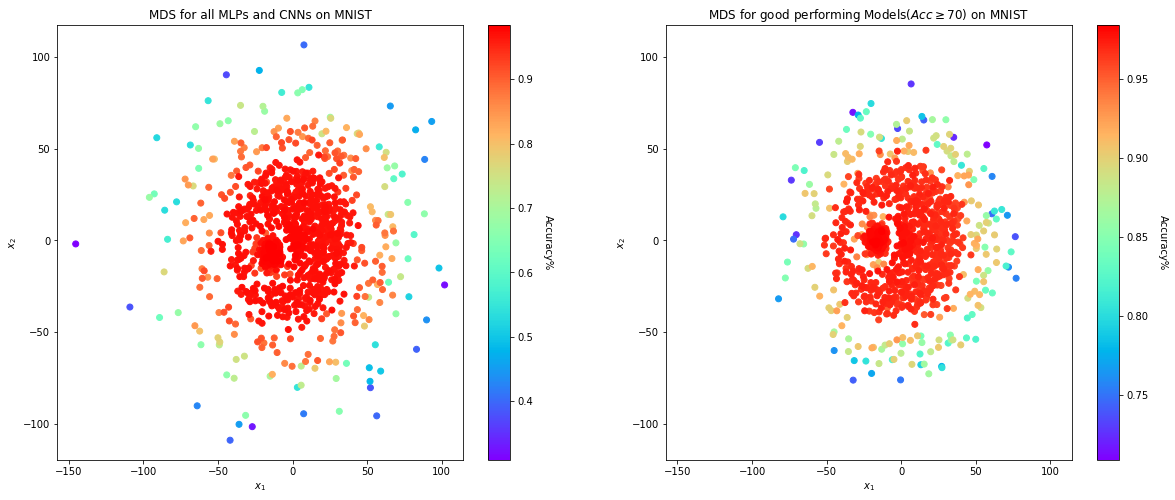

In [17]:
# Plot the corresponding embedding results for all MLPs and high-performing MLPs
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
x_lim = y_lim = None
for i, ax in enumerate(axes.flat):
  if i == 0:
    points = ax.scatter(mnist_model[:, 0], mnist_model[:, 1], c=acc_mnist, cmap='rainbow')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_title('MDS for all MLPs and CNNs on MNIST')
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    cbar = fig.colorbar(points, ax=ax)
    cbar.set_label('Accuracy%', labelpad=20, rotation=-90)
  else:
    points = ax.scatter(mnist_good_model[:, 0], mnist_good_model[:, 1], c=acc_mnist[over_70:], cmap='rainbow')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_title(r'MDS for good performing Models($Acc \geq 70%$) on MNIST')
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    cbar = fig.colorbar(points, ax=ax)
    cbar.set_label('Accuracy%', labelpad=20, rotation=-90)

Perform Different Embedding Methods for Input RDMs of all models

In [0]:
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)

# Store results from the following embedding methods
embedded_rdms= []

# Performing random projection method on Euclidean model RDM based on Fashion-MNIST dataset
rp = random_projection.SparseRandomProjection(n_components=2, random_state=5)
embedded_rdms.append(rp.fit_transform(all_models))

# Dimensionality reduction using truncated SVD (aka LSA)
pca = decomposition.TruncatedSVD(n_components=2)
embedded_rdms.append(pca.fit_transform(all_models))

# Non-linear dimensionality reduction through Isometric Mapping
iso = manifold.Isomap(n_neighbors=30, n_components=2)
embedded_rdms.append(iso.fit_transform(all_models))

# Locally linear embedding with standard method
clf = manifold.LocallyLinearEmbedding(n_neighbors=30, n_components=2, method='standard')
embedded_rdms.append(clf.fit_transform(all_models))

# Locally linear embedding with modified method
clf = manifold.LocallyLinearEmbedding(n_neighbors=30, n_components=2, method='modified')
embedded_rdms.append(clf.fit_transform(all_models))

# Multi-dimensional scaling embedding method
mds = manifold.MDS(n_components=2, max_iter=100, dissimilarity='precomputed')
embedded_rdms.append(mds.fit_transform(all_models))

# Random trees embedding method
hasher = ensemble.RandomTreesEmbedding(n_estimators=500, random_state=4, max_depth=10)
rdms_transformed = hasher.fit_transform(all_models)
pca = decomposition.TruncatedSVD(n_components=2)
embedded_rdms.append(pca.fit_transform(rdms_transformed))

# Spectral embedding for non-linear dimensionality reduction
embedder = manifold.SpectralEmbedding(n_components=2, random_state=0, eigen_solver='arpack')
embedded_rdms.append(embedder.fit_transform(all_models))

# t-distributed Stochastic Neighbor Embedding
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
embedded_rdms.append(tsne.fit_transform(all_models))

# Embedding results from the above methods
coordinates = np.array(embedded_rdms)

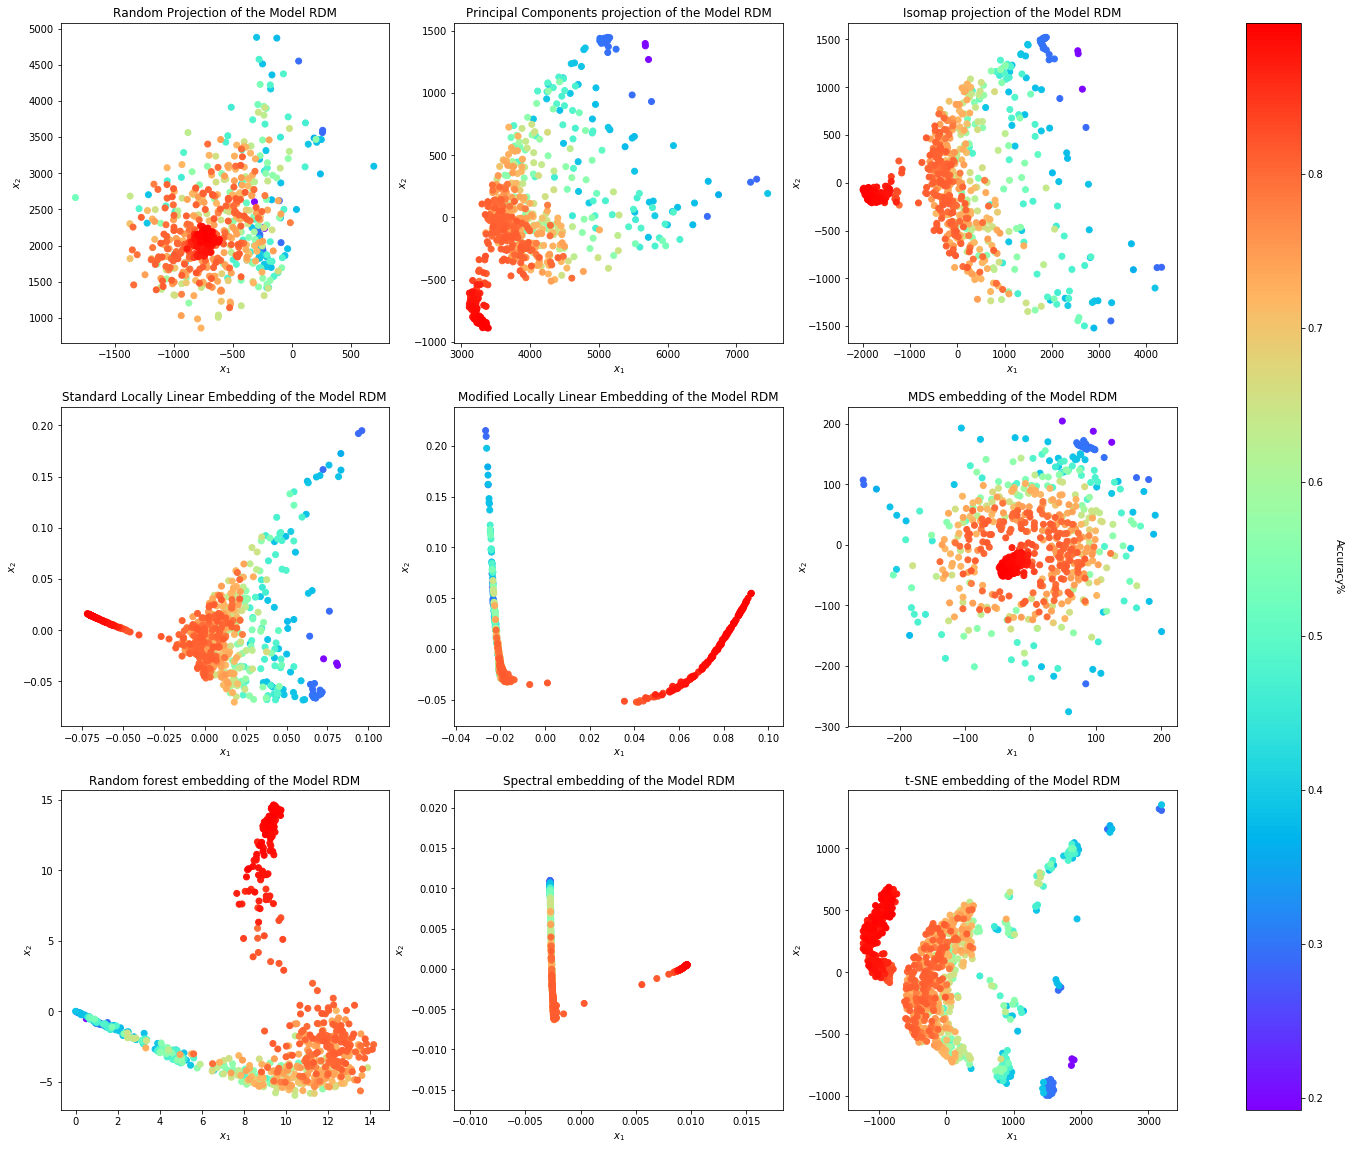

In [0]:
# Unify the color scale for different embedding results
norm = colors.Normalize(vmin=acc_sorted.min(), vmax=acc_sorted.max())
titles = ['Random Projection of the Model RDM', 'Principal Components projection of the Model RDM',
          'Isomap projection of the Model RDM', 'Standard Locally Linear Embedding of the Model RDM',
          'Modified Locally Linear Embedding of the Model RDM', 'MDS embedding of the Model RDM',
          'Random forest embedding of the Model RDM', 'Spectral embedding of the Model RDM',
          't-SNE embedding of the Model RDM']

fig, axes = plt.subplots(3, 3, figsize=(25, 20))
for i, ax in enumerate(axes.flat):
  points = ax.scatter(coordinates[i, :, 0], coordinates[i, :, 1], c=acc_fashion, cmap='rainbow', norm=norm)
  ax.set_xlabel(r'$x_1$')
  ax.set_ylabel(r'$x_2$')
  ax.set_title(titles[i])
    
cbar = fig.colorbar(points, ax=axes.ravel().tolist())
cbar.set_label('Accuracy%', labelpad=20, rotation=-90)

Apply again the aforementioned embedding methods to model RDM based on the MNIST Dataset

In [0]:
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)

embedded_rdms= []

rp = random_projection.SparseRandomProjection(n_components=2, random_state=5)
embedded_rdms.append(rp.fit_transform(mnist_rdm))

pca = decomposition.TruncatedSVD(n_components=2)
embedded_rdms.append(pca.fit_transform(mnist_rdm))

iso = manifold.Isomap(n_neighbors=30, n_components=2)
embedded_rdms.append(iso.fit_transform(mnist_rdm))

clf = manifold.LocallyLinearEmbedding(n_neighbors=30, n_components=2, method='standard')
embedded_rdms.append(clf.fit_transform(mnist_rdm))

clf = manifold.LocallyLinearEmbedding(n_neighbors=30, n_components=2, method='modified')
embedded_rdms.append(clf.fit_transform(mnist_rdm))

mds = manifold.MDS(n_components=2, max_iter=100, dissimilarity='precomputed')
embedded_rdms.append(mds.fit_transform(mnist_rdm))

hasher = ensemble.RandomTreesEmbedding(n_estimators=500, random_state=4, max_depth=10)
rdms_transformed = hasher.fit_transform(mnist_rdm)
pca = decomposition.TruncatedSVD(n_components=2)
embedded_rdms.append(pca.fit_transform(rdms_transformed))

embedder = manifold.SpectralEmbedding(n_components=2, random_state=0, eigen_solver='arpack')
embedded_rdms.append(embedder.fit_transform(mnist_rdm))

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
embedded_rdms.append(tsne.fit_transform(mnist_rdm))

coordinates = np.array(embedded_rdms)

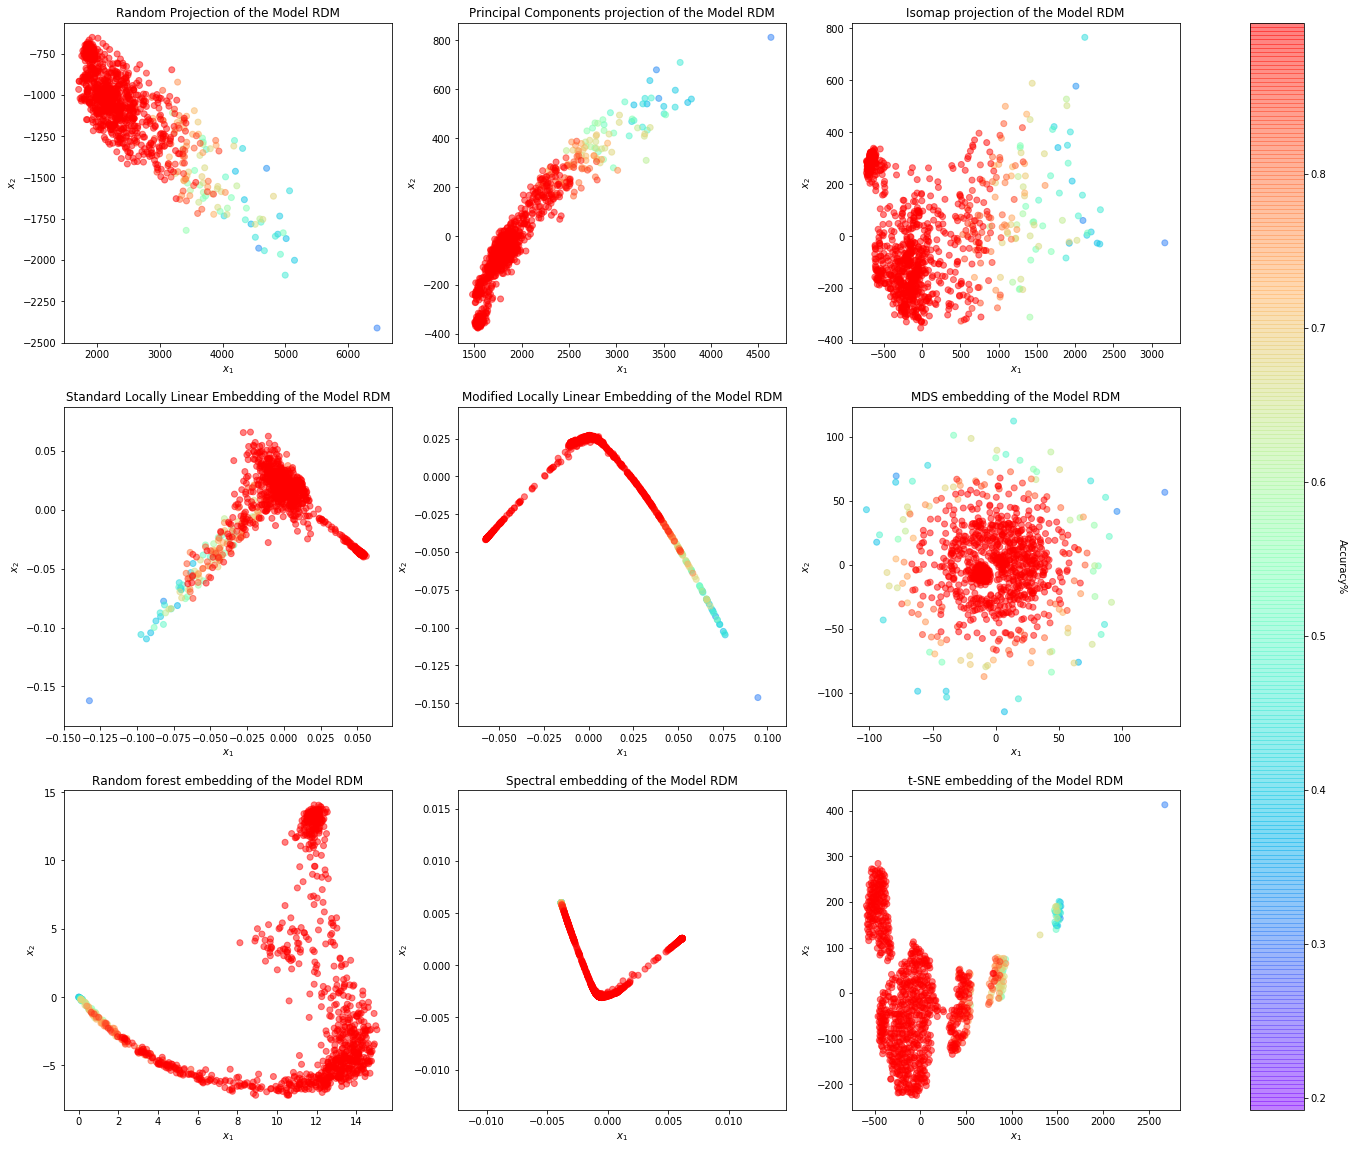

In [0]:
norm = colors.Normalize(vmin=acc_sorted.min(), vmax=acc_sorted.max())
titles = ['Random Projection of the Model RDM', 'Principal Components projection of the Model RDM',
          'Isomap projection of the Model RDM', 'Standard Locally Linear Embedding of the Model RDM',
          'Modified Locally Linear Embedding of the Model RDM', 'MDS embedding of the Model RDM',
          'Random forest embedding of the Model RDM', 'Spectral embedding of the Model RDM',
          't-SNE embedding of the Model RDM']

fig, axes = plt.subplots(3, 3, figsize=(25, 20))
for i, ax in enumerate(axes.flat):
  points = ax.scatter(coordinates[i, :, 0], coordinates[i, :, 1], c=acc_mnist, cmap='rainbow', norm=norm, alpha=0.5)
  ax.set_xlabel(r'$x_1$')
  ax.set_ylabel(r'$x_2$')
  ax.set_title(titles[i])
    
cbar = fig.colorbar(points, ax=axes.ravel().tolist())
cbar.set_label('Accuracy%', labelpad=20, rotation=-90)

# RSA on earlier Layers

In [20]:
# Dataframe, which contains all necessary infos about our trained models
# 1) index
# 2) "Unnamed: 0": model number
# 3) "acc": accuracy of this trained model
# 4) "loc": file name for model's final checkpoint
# 5) "model_type": 0-MLP, 1-CNN
# 6) "index": the same with "Unnamed: 0", viz., model number
acc_df = pd.read_csv('gdrive/My Drive/NI Project - RSA/euclidean_fashionmnist2_400_df.csv')
conv_index = acc_df['model_type']==1
mlp_index = acc_df['model_type']==0

# Model RDMs based on Euclidean distance of all models
all_models = pd.read_csv('gdrive/My Drive/NI Project - RSA/euclidean_fashionmnist2_400.csv').to_numpy()
# Remove the first column(model index)
all_models = all_models[:,1:]
# Euclidean model RDM for all CNNs
rdm_convnet = all_models[:,conv_index][conv_index,:]
# Euclidean model RDM for all MLPs
rdm_mlp = all_models[:,mlp_index][mlp_index,:] 

print(rdm_mlp.shape)
print(rdm_convnet.shape)

acc_sorted_rounded = np.around(acc_df['acc'] * 100, 1)

(512, 512)
(141, 141)


Plot Model RDM based on Euclidean Distance

(564,)


[Text(0, 0.5, '19.2'),
 Text(0, 9.5, '48.5'),
 Text(0, 18.5, '65.5'),
 Text(0, 27.5, '73.5'),
 Text(0, 36.5, '79.8'),
 Text(0, 45.5, '81.2')]

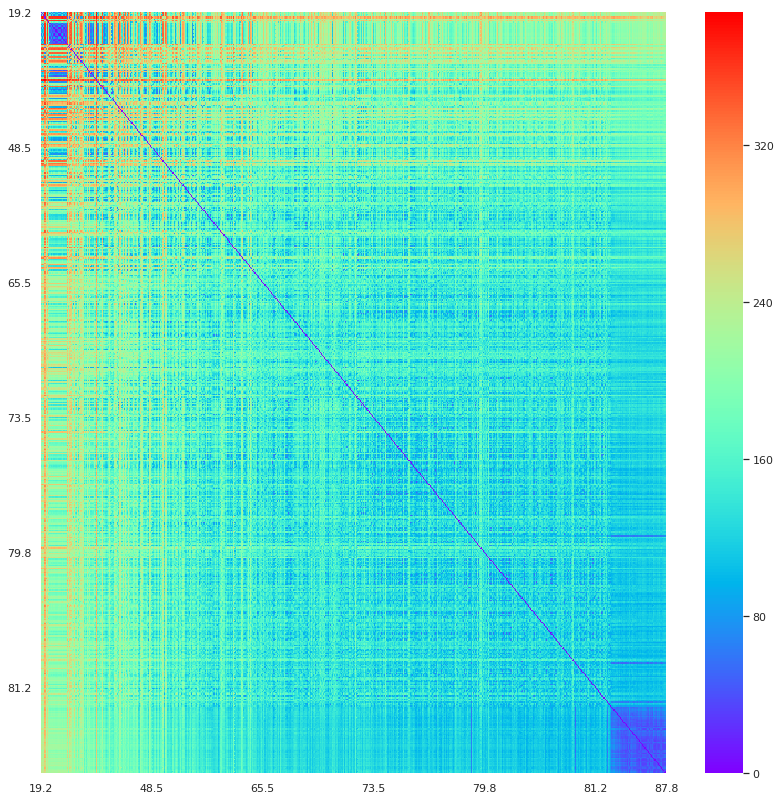

In [22]:
plt.figure(figsize=(14,14))
sns.set(font_scale=1)
# Plot model RDM for all MLP and the first 52 CNN models
ax = sns.heatmap(all_models[:-89,:-89], cmap="rainbow")
print(acc_sorted_rounded.to_numpy()[:-89].shape)

# Make labels for both axes sparser
x_range = [i for i in np.arange(0, acc_sorted_rounded.to_numpy()[:-89].shape[0], 100)]
x_range.append(acc_sorted_rounded.to_numpy()[:-89].shape[0])
ax.set_xticks(x_range)
x_ticks = [ i for i in acc_sorted_rounded.to_numpy()[:-89:100] ]
x_ticks.append(acc_sorted_rounded.to_numpy()[-89])
ax.set_xticklabels(x_ticks, rotation=0)
ax.set_yticks(range(0, acc_sorted_rounded.to_numpy()[:-89].shape[0], 100))
ax.set_yticklabels(acc_sorted_rounded.to_numpy()[:-89:100])

Plot Model RDM based on rank Correlation

[Text(0, 0.5, '19.2'),
 Text(0, 9.5, '48.5'),
 Text(0, 18.5, '65.5'),
 Text(0, 27.5, '73.5'),
 Text(0, 36.5, '79.8'),
 Text(0, 45.5, '81.2')]

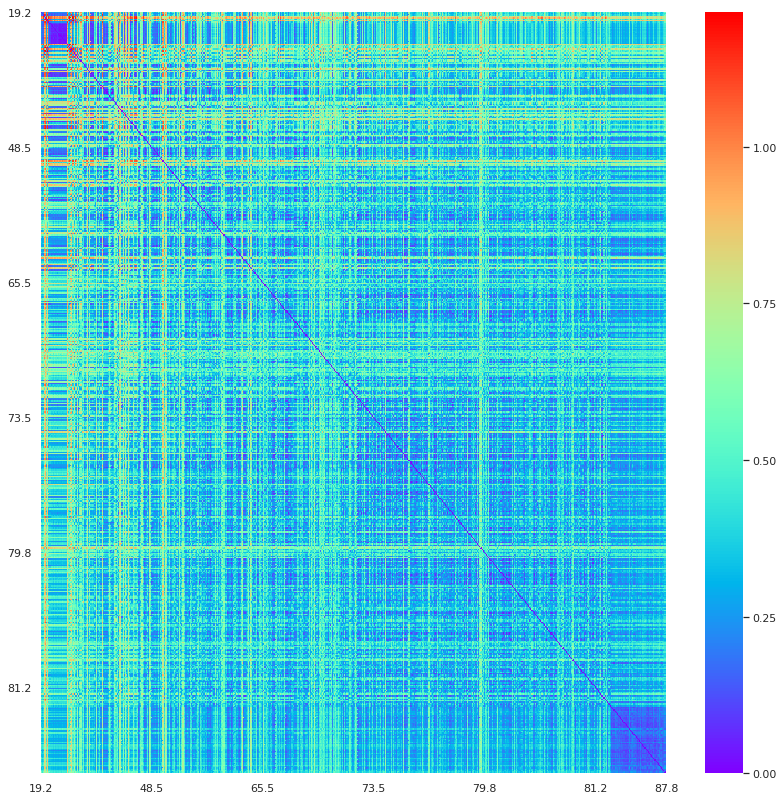

In [23]:
# Rank-correlation model RDM for all models
corr = np.load('gdrive/My Drive/NI Project - RSA/rdm_rank_correlation.data', allow_pickle=True)

# Display model RDM
plt.figure(figsize=(14,14))
sns.set(font_scale=1)
# Select all MLP and the first 52 CNN models
ax = sns.heatmap(corr[:-89,:-89], cmap="rainbow")
acc_sorted_rounded = np.around(acc_df['acc'] * 100, 1)
x_range = [i for i in np.arange(0, acc_sorted_rounded.to_numpy()[:-89].shape[0], 100)]
x_range.append(acc_sorted_rounded.to_numpy()[:-89].shape[0])
ax.set_xticks(x_range)
x_ticks = [ i for i in acc_sorted_rounded.to_numpy()[:-89:100] ]
x_ticks.append(acc_sorted_rounded.to_numpy()[-89])
ax.set_xticklabels(x_ticks, rotation=0)
ax.set_yticks(range(0, acc_sorted_rounded.to_numpy()[:-89].shape[0], 100))
ax.set_yticklabels(acc_sorted_rounded.to_numpy()[:-89:100])

 Model RDM based on Euclidean distance for the previous three Layers

In [0]:
# Euclidean model RDM based on activation of the first fully-connected hidden layer in our models
rdm_1st = np.load('gdrive/My Drive/NI_Project/fourth_to_last_layer.dat', allow_pickle=True)

# Euclidean model RDM based on activation of the second fully-connected hidden layer in our models
rdm_2nd = np.load('gdrive/My Drive/NI_Project/third_to_last_layer.dat', allow_pickle=True)

# Euclidean model RDM based on activation of the third fully-connected hidden layer(the penultimate layer) in our models
rdm_3rd = pd.read_csv('gdrive/My Drive/NI Project - RSA/euclidean_fashionmnist2_400.csv').to_numpy()[:,1:]

# Reduce/Average model RDM per column to observe the general tendency
avg_1st = np.mean(rdm_1st, axis=0)
avg_2nd = np.mean(rdm_2nd, axis=0)
avg_3rd = np.mean(rdm_3rd, axis=0)

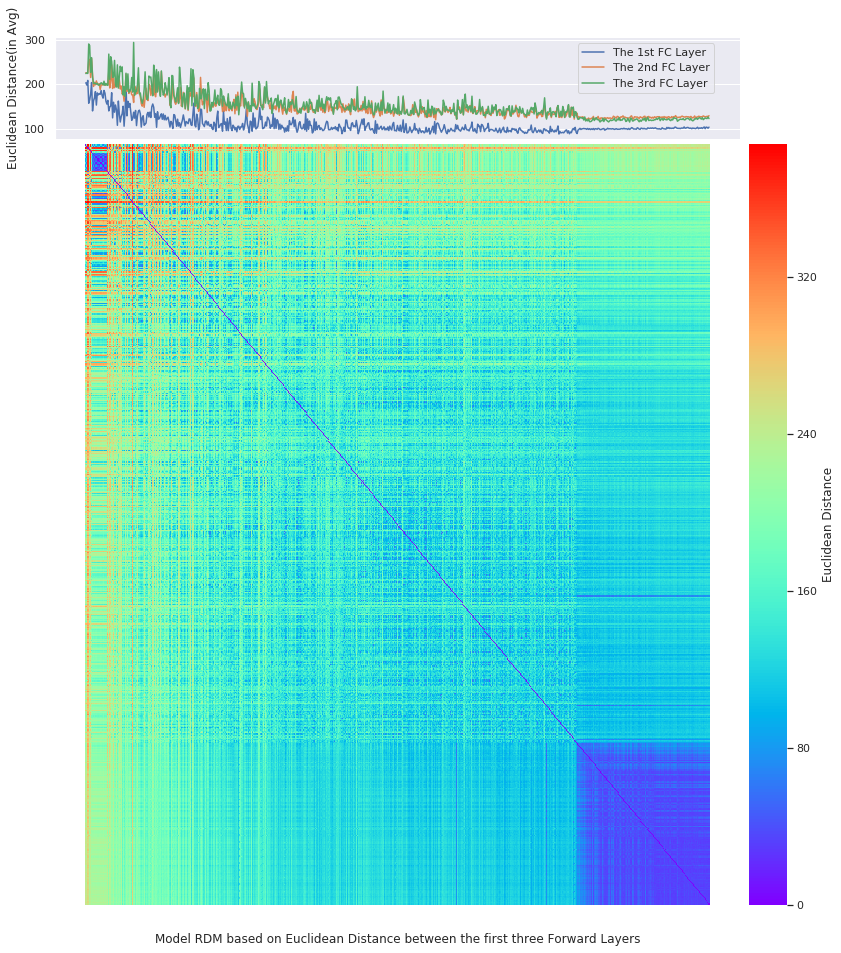

In [0]:
plt.figure(figsize=(14,14))
# Depict model RDM from the third fully-connected hidden layer(the penultimate layer)
axHeat = sns.heatmap(rdm_3rd, cmap='rainbow', 
                     cbar_kws={'label': 'Euclidean Distance'})
axHeat.set_xticks([])
axHeat.set_yticks([])
axHeat.text(0.5, -0.05, "Model RDM based on Euclidean Distance between the first three Forward Layers", 
            size=12, ha="center", 
            transform=axHeat.transAxes)

rect_histx = [0.095, 0.885, 0.68, 0.1] 
axHistx = plt.axes(rect_histx)
# Plot those three averaged 1D-model RDMs 
axHistx.plot(range(rdm_1st.shape[0]), avg_1st, label='The 1st FC Layer')
axHistx.plot(range(rdm_1st.shape[0]), avg_2nd, label='The 2nd FC Layer')
axHistx.plot(range(rdm_1st.shape[0]), avg_3rd, label='The 3rd FC Layer')
axHistx.set_xticks([])
axHistx.set_ylabel('Euclidean Distance(in Avg)')
axHistx.spines['top'].set_visible(False)
axHistx.spines['right'].set_visible(False)
axHistx.spines['bottom'].set_visible(False)
plt.legend(loc=0, bbox_to_anchor=(0.97, 1.0))
plt.show()

Smoothed Curves of averaged Model RDM in those three Layers

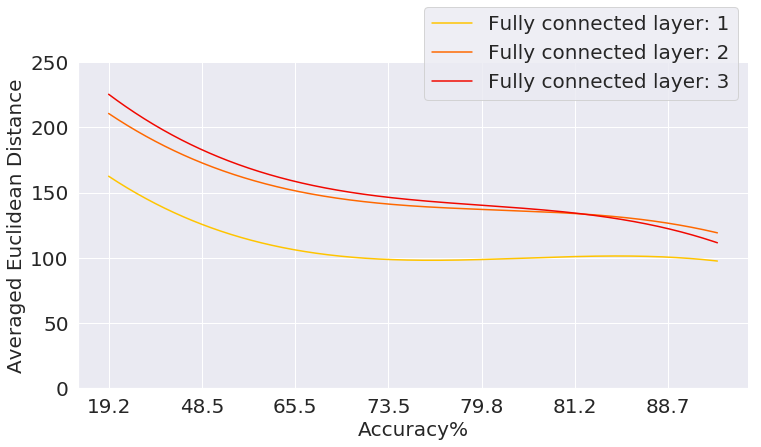

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Apply 1D-least squares polynomial fit method to smooth those three averaged model RDMs
z_1st = np.polyfit(np.arange(0, rdm_1st.shape[0]), avg_1st, 3)
p_1st = np.poly1d(z_1st)

z_2nd = np.polyfit(np.arange(0, rdm_1st.shape[0]), avg_2nd, 3)
p_2nd = np.poly1d(z_2nd)

z_3rd = np.polyfit(np.arange(0, rdm_1st.shape[0]), avg_3rd, 3)
p_3rd = np.poly1d(z_3rd)

xp = np.linspace(0, rdm_1st.shape[0], rdm_1st.shape[0])

# Different hue of line indicates different layer
# The darker, the deeper
colors = pl.cm.jet(np.linspace(0.7,0.9,3))

ax.plot(xp, p_1st(xp), label='Fully connected layer: 1', color=colors[0])
ax.plot(xp, p_2nd(xp), label='Fully connected layer: 2', color=colors[1])
ax.plot(xp, p_3rd(xp), label='Fully connected layer: 3', color=colors[2])
ax.set_xticks(range(0, acc_sorted_rounded.to_numpy()[:].shape[0], 100))
ax.set_xticklabels(acc_sorted_rounded.to_numpy()[::100])
ax.set_ylim(bottom=0, top=250)
ax.set_xlabel(r'Accuracy%', fontsize=20)
ax.set_ylabel('Averaged Euclidean Distance', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.setp(ax.get_xticklabels(), fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=20)
plt.legend(loc=0, bbox_to_anchor=(1.0, 1.2), prop={'size': 20})